In [22]:
import base64
from datetime import date, datetime
import json
import os
import random
import re
import time

import numpy as np
import pandas as pd

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import font_manager, rc
import seaborn as sns
plt.rcParams['axes.unicode_minus'] = False
# Jupyter Notebook
%matplotlib inline
%config InlineBackend.figure_format='retina'

from IPython.display import display
from tqdm import tqdm

# Set random seed for reproducibility
def set_seeds(seed=777):
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    np.random.seed(seed)

SEED = 777
set_seeds(SEED)
print(f'Random seed set to: {SEED}')
# Checking
print(np.random.rand(3))
set_seeds(SEED)
print(np.random.rand(3))

def print_all(df): 
    with pd.option_context('display.max_rows',None):
        with pd.option_context('display.max_columns',None):
            with pd.option_context('display.float_format', '{:,.4f}'.format):
                with pd.option_context('display.float_format', '{:,.4f}'.format):
                    print(df.shape)
                    display(df)

def print_cols(df, n=5): 
    with pd.option_context('display.max_columns',None):
        with pd.option_context('display.float_format', '{:,.4f}'.format):
            print(df.shape)
            display(df[:n])

Random seed set to: 777
[0.15266373 0.30235661 0.06203641]
[0.15266373 0.30235661 0.06203641]


In [23]:
# ===================================================================
# Configuration: path
from pathlib import Path

# Get the path of the current script file
wd = Path("/Users/jihoonchoi/Downloads/cse847_project").resolve()
os.chdir(wd)

print("CWD:", Path.cwd())

# Move up one level to the parent directory
# PARENT_DIR = os.path.dirname(os.getcwd())

# Path to certain file
# EXCEL_FILE_PATH = os.path.join(PARENT_DIR, 'data', 'meijer_scraped_data_upc_with_category.xlsx')

# DATA_ROOT = os.path.join(CURRENT_DIR, 'data')
# print(DATA_ROOT)

CWD: /Users/jihoonchoi/Downloads/cse847_project


# Logistic Regression with L2-Penalty

### Logistic Regression Core Model Setup

In [24]:
# sigmoid link function
def sigmoid(z):
    # clip inputs to avoid overflow in exp for very large magnitude values
    z = np.clip(z, -50.0, 50.0)
    return 1.0 / (1.0 + np.exp(-z)) # standard logistic transform returning values in (0,1)

# logistic regression loss (objective) function and its gradient
def logreg_loss_and_grad(w, X, y, lamda):
    """
    Inputs
    w: parameter (coefficient) vector (d,)
    X: design matrix with intercept if you added it (n,d)
    y: target labels in {0,1} (n,)
    lamda : L2 penalty strength (scalar)

    Returns
      loss: scalar logistic loss with L2 penalty
      grad: gradient vector (d,)
    """
    
    # n of observations
    n = X.shape[0]
    # linear predictor z_i = X_i^T w for all row at once
    z = X @ w
    # predicted probabilities (p_i = sigmoid(z_i))
    p = sigmoid(z)

    # average negative log-likelihood
    # = mean(-y*log(p) - (1-y)*log(1-p))
    data_loss = -np.mean(y * np.log(p) + (1 - y) * np.log(1 - p))

    # L2 penalty term (from Gussian prior with variance of sigma^2 = 1/lambda)
    reg_loss = 0.5 * lamda * (w @ w)

    # total objective function
    loss = data_loss + reg_loss

    grad = (X.T @ (p - y)) / n + lamda * w
    return loss, grad

def add_intercept(X):
    # a column of ones to X to model an intercept
    return np.c_[np.ones(X.shape[0]), X]

def predict_prob(w, X):
    # probability of class 1 given features (X)
    return sigmoid(X @ w)

def predict_label(w, X, thresh=0.5):
    # convert probs to hard labels using a threshold (0.5)
    return (predict_prob(w, X) >= thresh).astype(int)

def accuracy(w, X, y, thresh=0.5):
    # fraction or proportion of correct predictions (thr = 0.5)
    return np.mean(predict_label(w, X, thresh) == y)

### Optimizer Setup

In [25]:
# Armijo Backtracking (Approximated Line Search)
def armijo_backtracking(fg, x, p, f0=None, g0=None, alpha0=1.0, c1=1e-4, tau=0.5, max_bt=20):
    """
    fg: function that returns (f(x), grad f(x))
    x: current point (vector)
    p: search direction (typically -grad)
    f0, g0: optional cached f(x), grad f(x) at the current x to avoid recompute
    alpha0: initial step size guess
    c1: Armijo constant in (0, 1). Smaller means stricter decrease requirement
    tau: backtracking shrink factor in (0, 1). Default is 0.5
    max_bt: maximum backtracking iterations
    returns alpha or None if no satisfactory step found
    """

    # use predefined f and g if given, if not, compute those
    if f0 is None or g0 is None:
        f0, g0 = fg(x)
    
    # directional derivative at x along p
    gTp = float(np.dot(g0, p))
    
    # start step size
    alpha = float(alpha0)

    # Armijo condition: f(x _ alpha * p) <= f(x) + c1 * alpha * g^T * p
    for _ in range(max_bt):
        x_try = x + alpha * p
        f_try, _ = fg(x_try)
        if f_try <= f0 + c1 * alpha * gTp:
            return alpha # sufficient decrease achieved
        alpha *= tau # if not, shrink and try again
    
    return None  # give up if could not satisfy sufficient decrease with max_bt

# Gradient Descent with fixed step size
def fit_gd_fixed(fg, w0, step=1e-2, tol=1e-6, max_iter=10000):
    """
    fg: function that returns (loss, grad) at w
    w0: starting weights
    step: fixed step size
    tol: stop when ||grad||_2 <= tol
    max_iter: cap on iterations
    returns (w, info) where info has status, iters, history[(k, loss, ||grad||)]
    """
    w = w0.copy()
    hist = []

    for k in range(max_iter):
        f, g = fg(w) # current loss and gradient
        gnorm = float(np.linalg.norm(g)) # gradient norm for stopping
        hist.append((k, f, gnorm))

        # convergence check
        if np.linalg.norm(g) <= tol:
            return w, {"status": 0, "iters": k, "history": hist}
        
        w = w - step * g # fixed step update
    
    # did not converged within max_iter    
    return w, {"status": 1, "iters": max_iter, "history": hist}

# Gradient Descent with Armijo Backtracking
def fit_gd_armijo(fg, w0, alpha0=1.0, tol=1e-6, max_iter=10_000,
                  c1=1e-4, tau=0.5, max_bt=20):    
    """
    fg: function that returns (loss, grad) at w
    w0: starting weights
    alpha0: initial step guess each iteration
    tol: stop when ||grad||_2 <= tol
    max_iter: max iterations
    c1, tau, max_bt: Armijo parameters

    returns (w, info) where info has status, iters, history[(k, loss, ||grad||)]
    """ 
    # working copy
    w = w0.copy()
    
    # history for plotting
    hist = []

    for k in range(max_iter):
        # evaluate objective and gradient at current point
        f, g = fg(w)

        # log progress
        hist.append((k, f, np.linalg.norm(g)))

        # first-order stopping rule
        if np.linalg.norm(g) <= tol:
            return w, {"status": 0, "iters": k, "history": hist}

        # choose the steepest descent direction
        p = -g

        # pic a step length using Armijo backtracking
        alpha = armijo_backtracking(fg, w, p, f0 = f, g0 = g, alpha0 = alpha0, 
                                    c1 = c1, tau = tau, max_bt = max_bt)
        # take a tiny step if line search failed
        if alpha is None:
            alpha = 1e-6

        # update iterate
        w = w + alpha * p
    return w, {"status": 1, "iters": max_iter, "history": hist}

In [26]:
# ---------- high level training wrapper ----------
def fit_logreg(X, y, lam=1.0, optimizer="gd_armijo",
               step=1e-2, tol=1e-6, max_iter=10000, alpha0=1.0):
    """
    X: array (n, d) without intercept column. This function will add one.
    y: array in {0,1}
    lam: L2 strength
    optimizer: "gd", "gd_armijo", "cg", "bfgs"
    step: used only for fixed-step GD
    alpha0: initial step for Armijo-based methods
    """
    # ensure array and add intercept
    Xb = add_intercept(np.asarray(X, dtype=float))
    yb = np.asarray(y, dtype=float).reshape(-1)

    # objective and gradient wrapper f(w), g(w)
    fg = lambda w: logreg_loss_and_grad(w, Xb, yb, lam)

    # start at zeros
    w0 = np.zeros(Xb.shape[1], dtype=float)

    # choose optimizer
    if optimizer == "gd":
        w, info = fit_gd_fixed(fg, w0, step=step, tol=tol, max_iter=max_iter)
    elif optimizer == "gd_armijo":
        w, info = fit_gd_armijo(fg, w0, alpha0=alpha0, tol=tol, max_iter=max_iter)
    else:
        raise ValueError("optimizer must be one of {'gd','gd_armijo','cg','bfgs'}")
    """ in development
    elif optimizer == "cg":
        w, info = fit_nlcg_prp(fg, w0, tol=tol, max_iter=max_iter)
    elif optimizer == "bfgs":
        w, info = fit_bfgs(fg, w0, tol=tol, max_iter=max_iter)
    """
    return w, info

# ---------- tiny helper to build arrays from your DataFrames ----------
def df_to_Xy(df, y_col):
    """
    Converts a DataFrame to (X,y). No scaling. No intercept.
    y is mapped to {0,1} if it looks like {-1,1}.
    """
    X = df.drop(columns=[y_col]).to_numpy(dtype=float)
    y = df[y_col].to_numpy()
    # map {-1,1} to {0,1} if needed
    if set(np.unique(y)).issubset({-1, 1}):
        y = ((y + 1) // 2).astype(int)
    else:
        y = y.astype(int)
    return X, y

### Import Dataset

In [27]:
CURRENT_DIR = os.getcwd()
print(CURRENT_DIR)

# 1. Load the preprocessed data
train_df = pd.read_csv("train_scaled.csv")
test_df  = pd.read_csv("test_scaled.csv")

# 2. Split into features (X) and target (y)
# Target column is 'def_pay'
X_train = train_df.drop(columns=["def_pay"])
y_train = train_df["def_pay"]

X_test = test_df.drop(columns=["def_pay"])
y_test = test_df["def_pay"]

# --- optional check ---
print("Train set:", X_train.shape, y_train.shape)
print("Test set:", X_test.shape, y_test.shape)
print("Sample features:\n", X_train.head())

/Users/jihoonchoi/Downloads/cse847_project
Train set: (24000, 26) (24000,)
Test set: (6000, 26) (6000,)
Sample features:
    limit_bal  sex_female       age     pay_1     pay_2     pay_3     pay_4  \
0  -0.676120           1 -1.134519 -0.469497 -0.400043 -0.388863 -0.344641   
1   0.940071           1  1.467205 -0.469497 -0.400043 -0.388863 -0.344641   
2   0.093495           0  0.057938 -0.469497 -0.400043 -0.388863 -0.344641   
3  -0.522197           0 -1.026114 -0.469497 -0.400043 -0.388863 -0.344641   
4  -0.907004           1 -1.459734 -0.469497 -0.400043 -0.388863 -0.344641   

      pay_5     pay_6  bill_amt1  ...  pay_amt2  pay_amt3  pay_amt4  pay_amt5  \
0 -0.312747 -0.319495  -0.081523  ... -0.167625 -0.181802 -0.216587 -0.096648   
1 -0.312747 -0.319495   0.019790  ... -0.175159 -0.183055 -0.184433 -0.186609   
2 -0.312747 -0.319495  -0.634328  ... -0.206593 -0.179296  1.122578 -0.322844   
3 -0.312747 -0.319495   0.546130  ... -0.072370 -0.048563 -0.052200 -0.003012   
4 -0

### Training Convergence Summary

In [28]:
w_gd, info_gd = fit_logreg(X_train, y_train, lam=1.0, optimizer="gd", step=1e-2)

print("Fixed GD:  iters =", info_gd["iters"],
      "  final loss =", info_gd["history"][-1][1],
      "  grad norm =", info_gd["history"][-1][2])

w_arm, info_arm = fit_logreg(X_train, y_train, lam=1.0, optimizer="gd_armijo", alpha0=1.0)

print("Armijo GD: iters =", info_arm["iters"],
      "  final loss =", info_arm["history"][-1][1],
      "  grad norm =", info_arm["history"][-1][2])

Fixed GD:  iters = 975   final loss = 0.6099178297143104   grad norm = 9.92656992218895e-07
Armijo GD: iters = 13   final loss = 0.6099178297140719   grad norm = 9.508887736401374e-07


### Convergence Curves

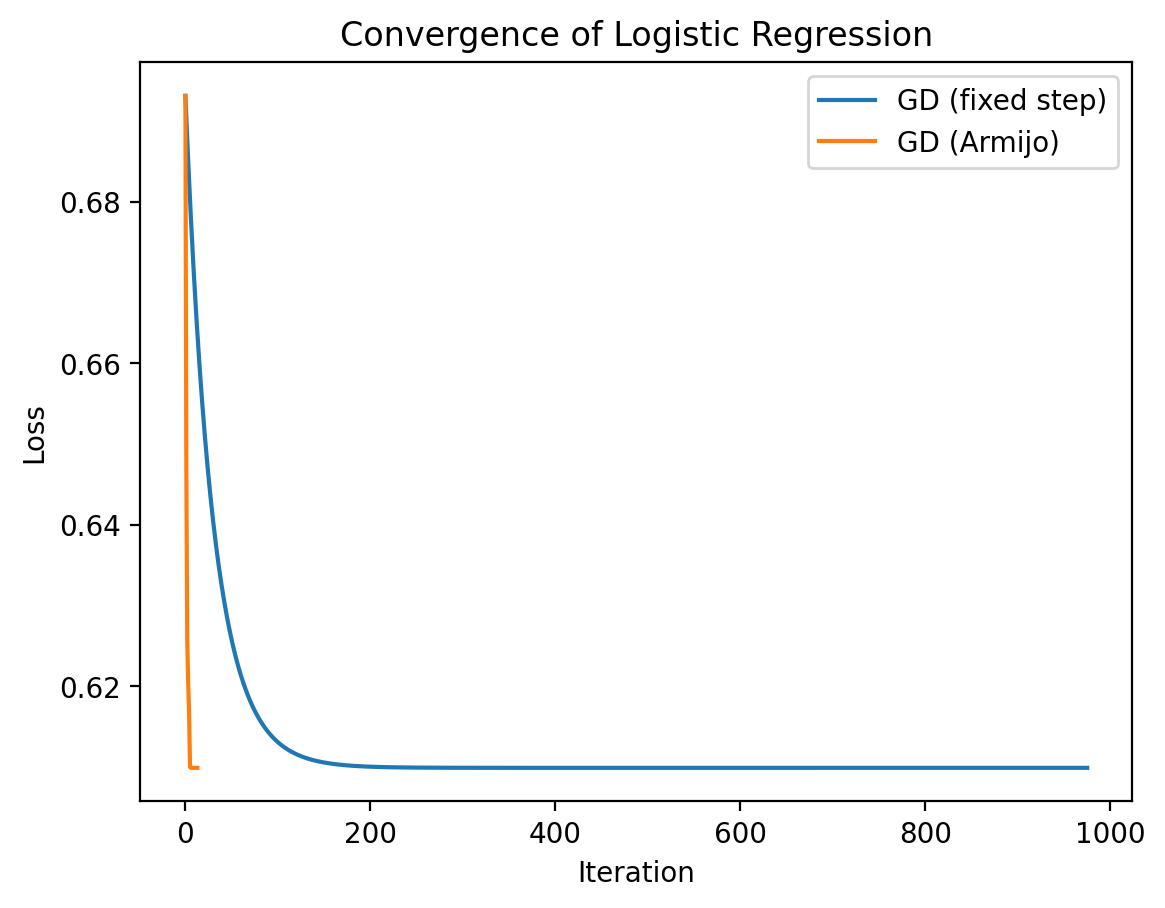

In [29]:
gd_hist = np.array(info_gd["history"])
arm_hist = np.array(info_arm["history"])

plt.plot(gd_hist[:,0], gd_hist[:,1], label="GD (fixed step)")
plt.plot(arm_hist[:,0], arm_hist[:,1], label="GD (Armijo)")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.legend()
plt.title("Convergence of Logistic Regression")
plt.show()

### Final Weights & Accuracy

In [30]:
acc_gd = accuracy(w_gd, add_intercept(X_test), y_test)
acc_arm = accuracy(w_arm, add_intercept(X_test), y_test)

print(f"Fixed-step GD accuracy: {acc_gd:.3f}")
print(f"Armijo GD accuracy: {acc_arm:.3f}")

Fixed-step GD accuracy: 0.806
Armijo GD accuracy: 0.806
